# 📄 Problem Statement: Customer Churn Prediction


🎯 Objective

The goal of this project is to build a machine learning model that can accurately predict whether a customer is likely to churn (i.e., stop using the service) based on historical data. Early identification of churn-prone customers allows the company to proactively implement retention strategies, improve customer satisfaction, and minimize revenue loss.

🧠 Context

Customer churn is a critical metric in subscription-based industries such as telecom, banking, SaaS, and e-commerce. Understanding the key drivers of churn and predicting it in advance enables businesses to take timely and targeted actions.

📁 Dataset

We are using the **scikit-learn "churn-prediction" dataset** hosted on Hugging Face. This dataset includes customer demographic information, service usage patterns, and a churn label indicating whether the customer discontinued the service.

💼 Business Goals

- Predict the likelihood of customer churn with high accuracy and recall.

- Identify key features that influence customer churn behavior.

- Provide actionable insights and business recommendations to reduce churn.

- Build a stakeholder-friendly dashboard using Power BI.

✅ Success Criteria

- A well-performing classification model evaluated on metrics such as **accuracy**, **precision**, **recall**, **F1-score**, and **ROC-AUC**.

- Identification of the top churn indicators using **feature importance** or **SHAP values**.

- Clear and practical business recommendations based on model results and analysis.

---

> Let’s dive into the data and start analyzing churn behavior!

# 1. Dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import classification_report, accuracy_score

In [2]:
dataset = pd.read_csv('dataset.csv')

In [3]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
dataset.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
dataset.columns.to_list()

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [6]:
dataset.shape

(7043, 21)

# 2. Data Cleaning

In [7]:
dataset.drop('customerID', axis=1, inplace=True)

print("Remaining columns:\n")
dataset.columns.to_list()

Remaining columns:



['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [8]:
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

In [9]:
dataset.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
dataset.dropna(subset=['TotalCharges'], inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [11]:
print("Shape of dataset after dropping rows: ", dataset.shape)

Shape of dataset after dropping rows:  (7032, 20)


In [12]:
print("Null values left: ", dataset.isnull().sum())

Null values left:  gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


# 3. EDA

In [13]:
# Separate categorical and numerical columns
categorical_cols = dataset.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Churn')  

numerical_cols = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", categorical_cols)
print("Numerical features:", numerical_cols)

Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


## Countplots for Categorical Features

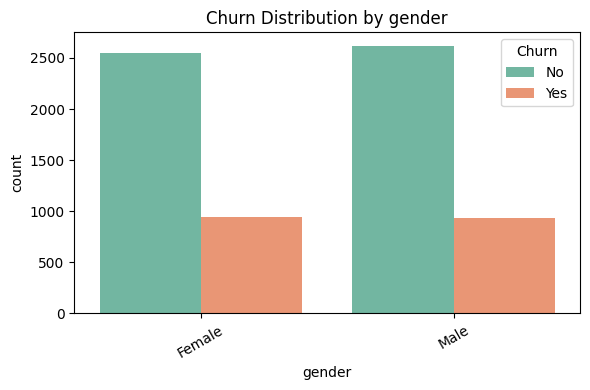

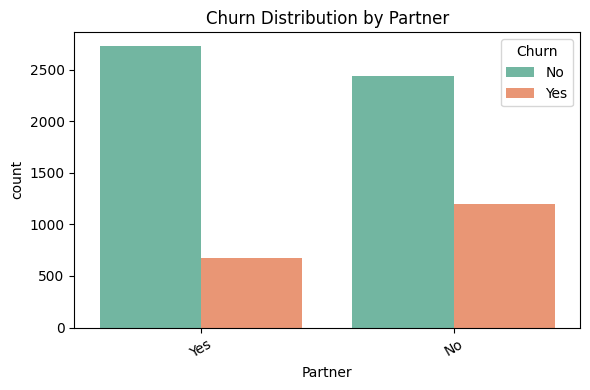

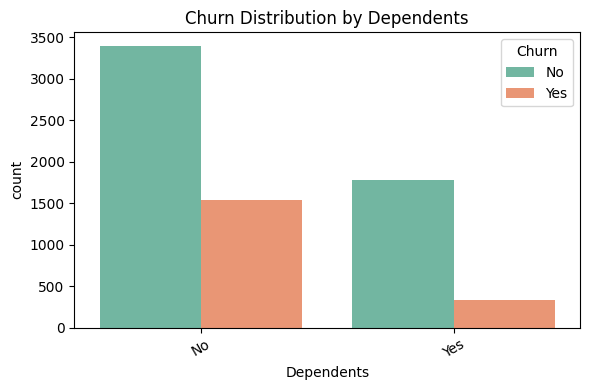

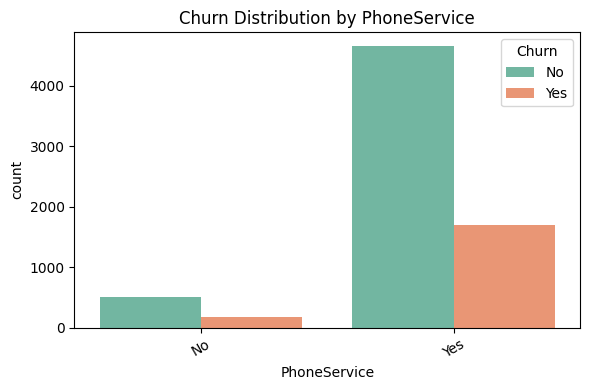

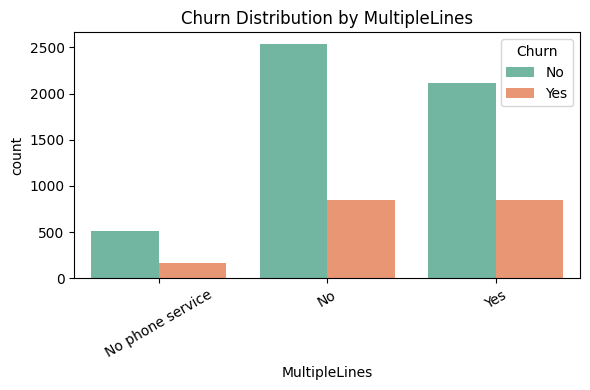

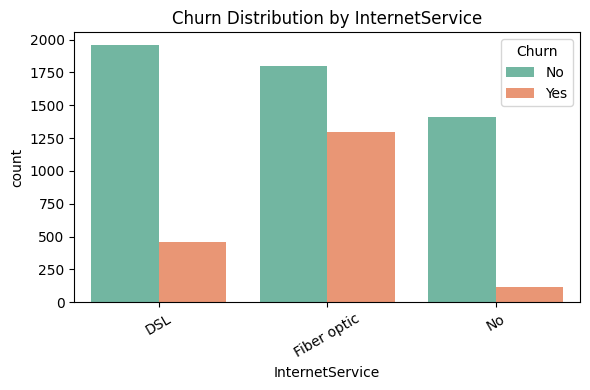

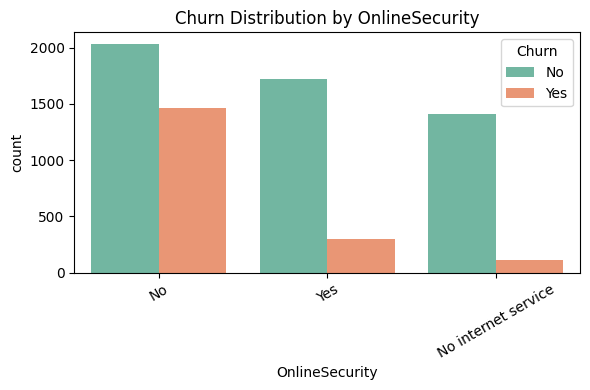

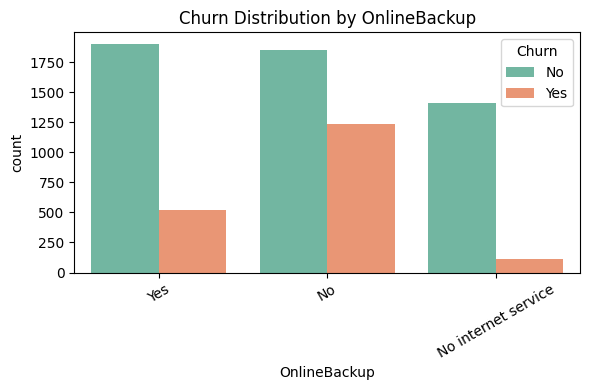

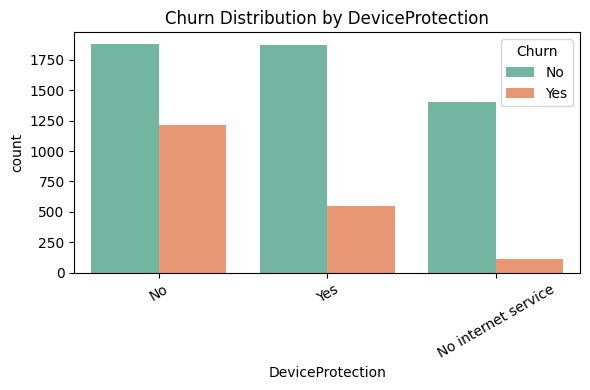

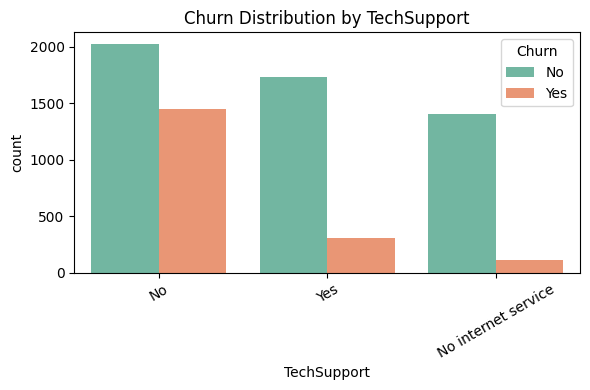

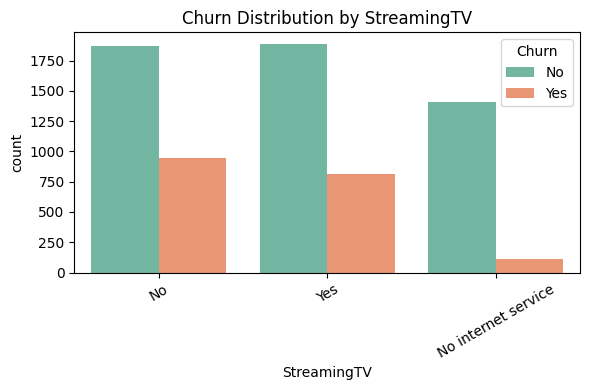

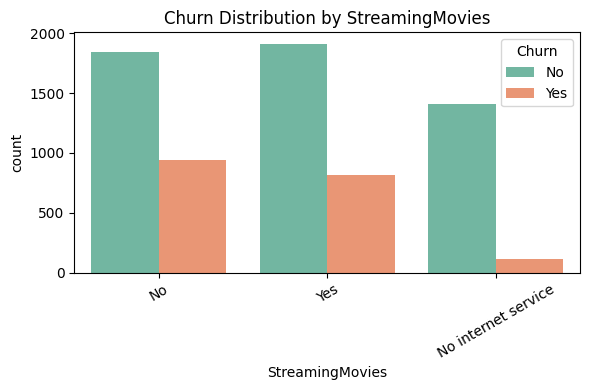

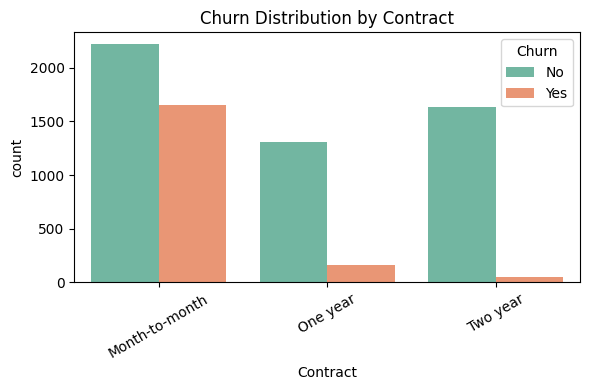

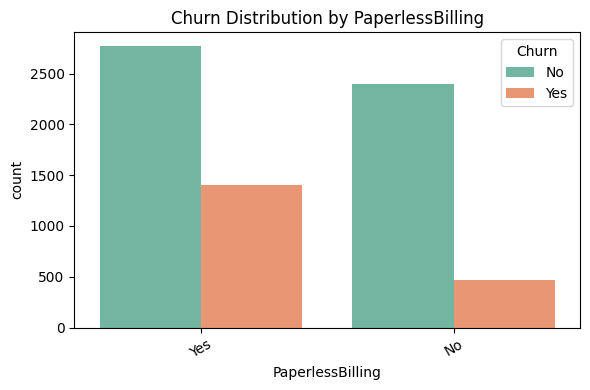

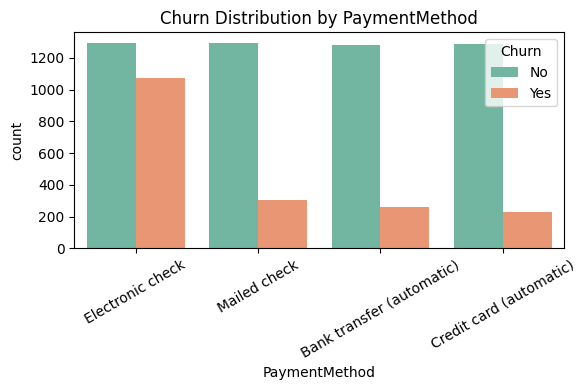

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot countplots for all categorical columns
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=dataset, x=col, hue='Churn', palette='Set2')
    plt.title(f'Churn Distribution by {col}')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


## Histograms and Boxplots for Numerical Features

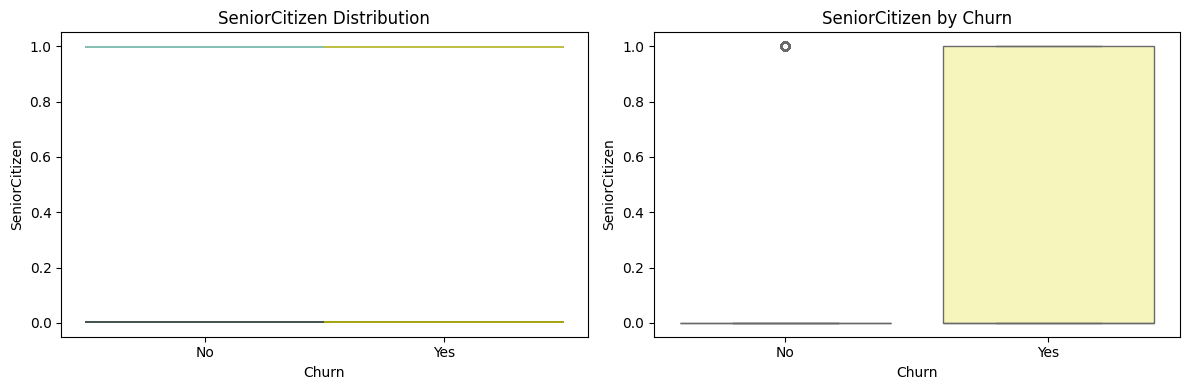

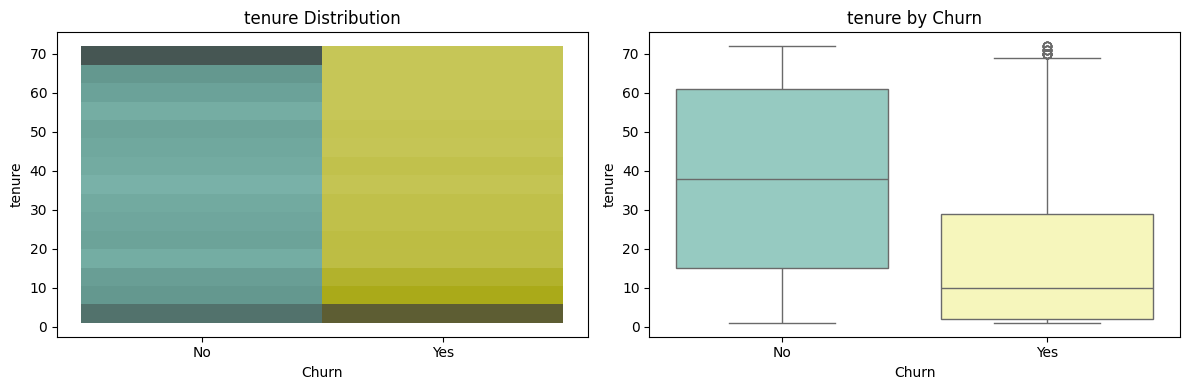

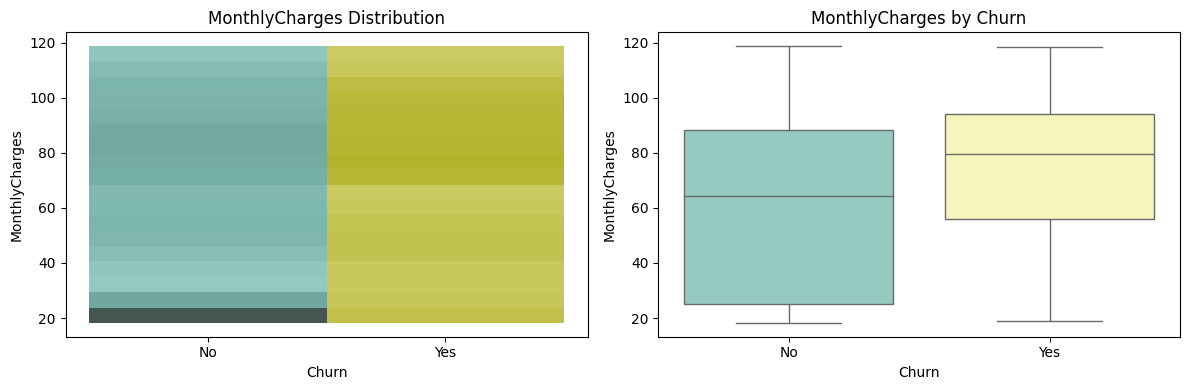

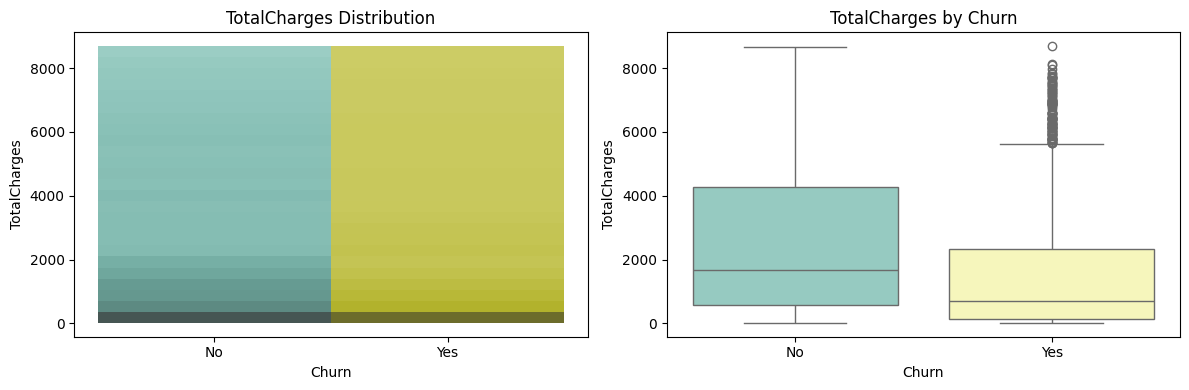

In [15]:
for col in numerical_cols:
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=dataset, x='Churn', y=col, hue='Churn', palette='Set3', legend=False)
    plt.title(f'{col} Distribution')

    # Boxplot by Churn
    plt.subplot(1, 2, 2)
    sns.boxplot(data=dataset, x='Churn', y=col, hue='Churn', palette='Set3', legend=False)
    plt.title(f'{col} by Churn')

    plt.tight_layout()
    plt.show()

📊 1. SeniorCitizen:

- 🔍 Distribution: Binary (0 = Not senior, 1 = Senior)

- 🎯 Insight: Most customers are not senior citizens, but the churn rate seems slightly higher among senior citizens.

- ✅ Model Usefulness: Moderate. Could be a useful feature due to its class imbalance vs. churn.

📊 2. Tenure:

- 🔍 Distribution: Wide spread from 0 to ~72 months.

- 🎯 Insight: Customers who churn tend to have shorter tenure (newer customers), Long-term customers are less likely to leave.

- ✅ Model Usefulness: High — strong correlation with churn.

📊 3. MonthlyCharges:

- 🔍 Distribution: Higher MonthlyCharges appears slightly associated with churn.

- 🎯 Insight: Churned customers tend to have higher monthly charges.

- ✅ Model Usefulness: High — pricing seems to influence churn.

📊 4. TotalCharges:

- 🔍 Distribution: Positively skewed (some high-value outliers).

- 🎯 Insight: Churned customers have lower total charges, likely due to shorter tenure.

- ✅ Model Usefulness: High — it indirectly reflects both tenure and spend.

# 4. Data Preprocessing

In [16]:
selected_features = ['Contract', 'tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'MonthlyCharges', 'PaymentMethod', 'PaperlessBilling']
X = dataset[selected_features].copy()
y = dataset["Churn"].map({'Yes': 1, 'No': 0})

In [17]:
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

In [18]:
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Churn
0    5163
1    1869
Name: count, dtype: int64
Churn
0    73.421502
1    26.578498
Name: proportion, dtype: float64


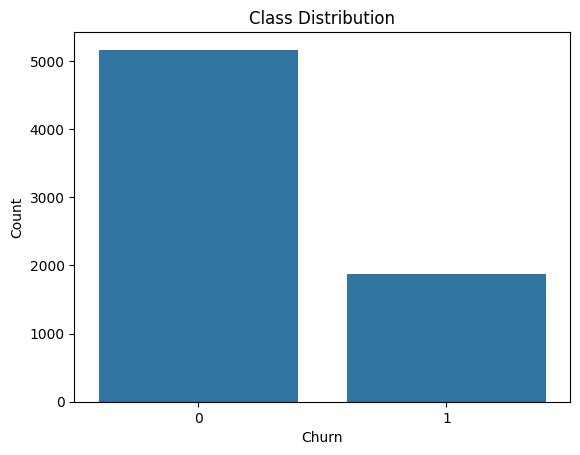

In [20]:
print(y.value_counts())

# Percentage distribution
print(y.value_counts(normalize=True) * 100)

# Visualize with bar plot
sns.countplot(x=y)
plt.title('Class Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# 5. Model Training

### Logistic Regression

In [21]:
lr_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit
lr_pipeline.fit(X_train, y_train)

# Predict
y_pred = lr_pipeline.predict(X_test)

In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.736318407960199
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407



### Random Forest

In [23]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=15,
        min_samples_split=10,
        class_weight='balanced'))
])

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

In [24]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7711442786069652
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1033
           1       0.55      0.72      0.62       374

    accuracy                           0.77      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.80      0.77      0.78      1407



In [25]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced']
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,  
    scoring='f1',  
    n_jobs=-1, 
    verbose=2
)

grid_search.fit(X_train, y_train)

# Best results
print("Best Parameters:", grid_search.best_params_)
print("Best Score (F1):", grid_search.best_score_)

# Evaluate on test set
best_model_rf = grid_search.best_estimator_
y_pred = best_model_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Best Score (F1): 0.6354903526067434
Accuracy: 0.7526652452025586
              precision    recall  f1-score   support

           0       0.90      0.74      0.82      1033
           1       0.52      0.78      0.63       374

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407



### XGBOOST

In [26]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(
       random_state=42, 
       eval_metric='mlogloss'))
])

xgb_pipeline.fit(X_train, y_train)

y_pred = xgb_pipeline.predict(X_test)   

In [27]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7505330490405118
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1033
           1       0.52      0.68      0.59       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407



In [28]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('SMOTE', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42))
])

grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (F1):", grid_search.best_score_)

best_model_xg = grid_search.best_estimator_
y_pred = best_model_xg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\himan\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:43:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "class_weight", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Score (F1): 0.7679595624301454
Accuracy: 0.7405828002842928
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      1033
           1       0.51      0.60      0.55       374

    accuracy                           0.74      1407
   macro avg       0.68      0.69      0.68      1407
weighted avg       0.76      0.74      0.75      1407



### Results

📊 Model Performance Comparison

| Model            | Accuracy | Precision (Class 0 / 1) | Recall (Class 0 / 1) | F1-Score (Class 0 / 1) | Weighted Avg F1 |
|------------------|----------|--------------------------|-----------------------|------------------------|------------------|
| LogisticRegression | 0.7363   | 0.90 / 0.50              | 0.72 / 0.79           | 0.80 / 0.61            | 0.75             |
| RandomForest      | 0.7527   | 0.90 / 0.52              | 0.74 / 0.78           | 0.82 / 0.63            | 0.76             |
| XGBoost           | 0.7406   | 0.84 / 0.51              | 0.79 / 0.60           | 0.82 / 0.55            | 0.75             |


### Exporting Model

In [29]:
import joblib
joblib.dump(lr_pipeline, 'models/lr.pkl')
joblib.dump(best_model_rf, 'models/rf.pkl')
joblib.dump(best_model_xg, 'models/xgb.pkl')

['models/xgb.pkl']

In [30]:
top_features = ['Contract', 'tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'MonthlyCharges', 'PaymentMethod', 'PaperlessBilling']
reduced_df = dataset[top_features + ['Churn']]

# Export to CSV
reduced_df.to_csv('dataset/churn_new_dataset.csv', index=False)

In [32]:
model_scores = {
    'Logistic Regression': {
        'Accuracy': 0.736,
        'Precision': {'Class 0': 0.90, 'Class 1': 0.50},
        'Recall': {'Class 0': 0.72, 'Class 1': 0.79},
        'F1-Score': {'Class 0': 0.80, 'Class 1': 0.61},
        'Weighted F1-Score': 0.75
    },
    'Random Forest': {
        'Accuracy': 0.753,
        'Precision': {'Class 0': 0.90, 'Class 1': 0.52},
        'Recall': {'Class 0': 0.74, 'Class 1': 0.78},
        'F1-Score': {'Class 0': 0.82, 'Class 1': 0.63},
        'Weighted F1-Score': 0.76
    },
    'XGBoost': {
        'Accuracy': 0.741,
        'Precision': {'Class 0': 0.84, 'Class 1': 0.51},
        'Recall': {'Class 0': 0.79, 'Class 1': 0.60},
        'F1-Score': {'Class 0': 0.82, 'Class 1': 0.55},
        'Weighted F1-Score': 0.75
    }
}

with open("models/model_scores.pkl", "wb") as f:
    pickle.dump(model_scores, f)
